In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Same plot but bootstrapped. Also, allow smaller s.

n = 2
Q = 10

df = pd.read_csv('./../../data/processed/ID_Y.csv')


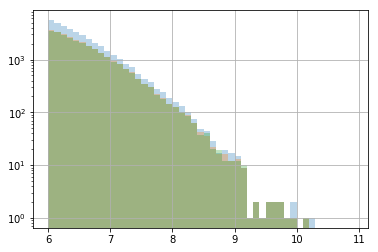

In [3]:
### Choice of data pre processing, for a near pareto with no entry/exit

sales = df.loc[df.IMPORT == 1].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
sales = sales.loc[sales.sum(1).sort_values().index]
    
# filt = sales.loc[sales.iloc[:, :-1].count(1) > 6]
filt = sales.loc[sales.count(1) > 6]

filt_fm = filt.copy()
for col in filt_fm:
    filt_fm[col] = filt_fm[col].fillna(filt.median(axis=1))
    
    
fig, ax = plt.subplots(1)

np.log10(sales.mean(1)).hist(bins = np.arange(6, 11, .1), alpha = .3, ax = ax)
np.log10(filt.mean(1)).hist(bins = np.arange(6, 11, .1), alpha = .3, ax = ax)
np.log10(filt_fm.mean(1)).hist(bins = np.arange(6, 11, .1), alpha = .3, ax = ax)
plt.yscale('log')
plt.show()

## Size distribution (Pareto)

$1 - CDF = \left( \frac{x_m}{x} \right)^\alpha$

 
-1.16 x + 11.69
18810
 
-1.136 x + 11.57
27626


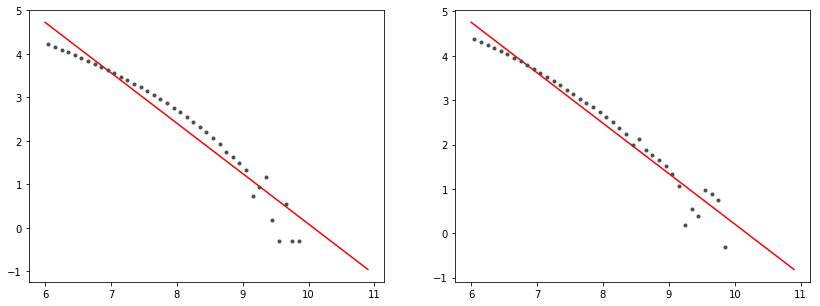

In [4]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

for i in [0, 1]:
    sales = df.loc[df.IMPORT == i].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
    sales = sales.loc[sales.sum(1).sort_values().index]

    # filt = sales.loc[sales.iloc[:, :-1].count(1) > 6]
    filt = sales.loc[sales.count(1) > 6]

    filt_fm = filt.copy()
    for col in filt_fm:
        filt_fm[col] = filt_fm[col].fillna(filt.median(axis=1))

    ## FIT PARETO
    log_vals = np.log10(filt_fm.mean(1))

    bins = pd.DataFrame(pd.cut(log_vals, np.arange(6, 10, .1)).dropna().value_counts(), columns=['n'])
    bins['mid'] = np.array([(b.mid).round(6) for b in bins.index.values])
    bins['CCDF'] = bins['n'].sum() - bins['n'].cumsum()
    bins['lCCDF'] = np.log10(bins['CCDF'] + .5)

    # bins.plot('mid', 'lCCDF', marker = '.', lw = 0)
    x = bins.mid.values; y = bins.lCCDF.values

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    xp = np.arange(6, 11, .1)

    ax = axs[i]
    ax.plot(xp, p(xp), '-', c = 'r', label='%.2f x + %.2f' % tuple(z))
    ax.plot(x, y, '.', label = 'observations', c = '.3')
    print(p)
    print(bins['n'].sum())
plt.show()

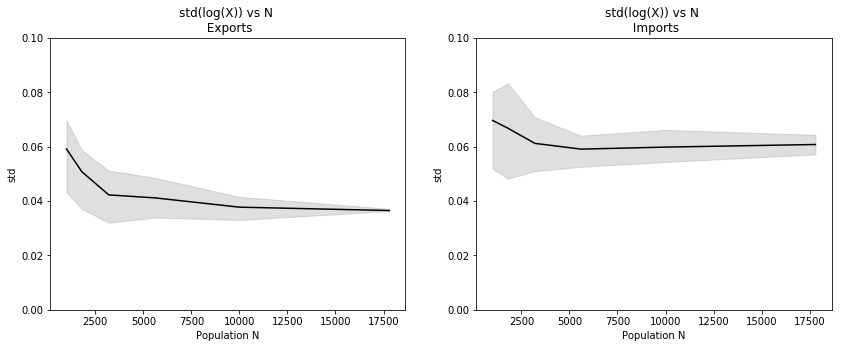

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))


for i in [0, 1]:
    sales = df.loc[df.IMPORT == i].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
    sales = sales.loc[sales.sum(1).sort_values().index]

    # Choose firms with presence in most sample, to avoid high distortion filling exit gaps
    sales_filt = sales.loc[sales.count(1) > 6]
    filt_fm = sales_filt.copy()

    # Large firms pareto filled median. 
    for col in filt_fm:
        filt_fm[col] = filt_fm[col].fillna(sales_filt.median(axis=1))

    # Hard cut for Pareto tail
    filt_fm = filt_fm.loc[filt_fm.mean(1) > 1e6]
    filt_fm.to_csv('./firms_data_'+str(i)+'.csv')

    # sales['q'] = pd.cut(sales.sum(1).cumsum(), Q, labels = range(Q))

    res_list = []
    res_list_h = []

    M = 50
    
    logn_vals = np.arange(3, np.log10(len(filt_fm)), .25)
    n_vals = np.round(10**logn_vals, -2)
    
    for n in n_vals:
        s_list = []
        h_list = []

        for m in range(M):
            n_sample = filt_fm.sample(int(n))
            s = np.log10(n_sample.sum()).std()
#             s = n_sample.sum().std()/(np.log(10)*n_sample.sum().mean())
            s_list += [s]
    
            # Herfindahl
            Si = n_sample.sum(1)
            h = np.sqrt((Si**2).sum())/(Si).sum()
            h_list += [h]

        res_list += [s_list]
        res_list_h += [h_list]

    result = pd.DataFrame(res_list, index = n_vals)
    result_h = pd.DataFrame(res_list_h, index = n_vals)

    ax = axs[i]
    ax.set_title(['std(log(X)) vs N \n Exports', 'std(log(X)) vs N \n Imports'][i])
#     ax.set_title(['std(X)/(ln(10) X) vs N \n Exports', 'std(log(X)) vs N \n Imports'][i])
    ax.fill_between(result.index, result.quantile(.25, 1), result.quantile(.75, 1), color = '.5', alpha = .25)
    ax.plot(result.index, result.mean(1), color = 'k')
    ax.set_ylim(0, .1)
    ax.set_xlabel('Population N')
    ax.set_ylabel('std')
    
plt.savefig('./test_fig_1.png')
plt.show()

In [6]:
# fig, axs = plt.subplots(1, 2, figsize = (14, 5))


# # for i in [0, 1]:
    
# i = 1

# sales = df.loc[df.IMPORT == i].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
# sales = sales.loc[sales.sum(1).sort_values().index]

# # Choose firms with presence in most sample, to avoid high distortion filling exit gaps
# sales_filt = sales.loc[sales.count(1) > 6]
# filt_fm = sales_filt.copy()

# # Large firms pareto filled median. 
# for col in filt_fm:
#     filt_fm[col] = filt_fm[col].fillna(sales_filt.median(axis=1))

# # Hard cut for Pareto tail
# filt_fm = filt_fm.loc[filt_fm.sum(1) > 1e7]

# # sales['q'] = pd.cut(sales.sum(1).cumsum(), Q, labels = range(Q))

# res_list = []

# M = 50
# n_vals = np.arange(500, 24500, 3000)

# for n in n_vals:
#     s_list = []

#     for m in range(M):
#         n_sample = filt_fm.sample(n)
#         s = np.log10(n_sample.sum()).std()
#         s_list += [s]

#     res_list += [s_list]

# result = pd.DataFrame(res_list, index = n_vals)

# ax = axs[i]
# ax.set_title(['std(log(X)) vs N \n Exports', 'std(log(X)) vs N \n Imports'][i])
# ax.fill_between(result.index, result.quantile(.25, 1), result.quantile(.75, 1), color = '.5', alpha = .25)
# ax.plot(result.index, result.mean(1), color = 'k')
# ax.set_ylim(0, .1)
# ax.set_xlabel('Population N')
# ax.set_ylabel('std')

# plt.show()

In [7]:
# M = 50

# block_res = []
# X_n = []

# logn_vals = np.arange(3, np.log10(len(filt_fm)), .25)
# n_vals = np.round(10**logn_vals, -2)


# nmqs  = []
    
# for n in n_vals:
#     X_list = []
#     s_list = []

#     for m in range(M):
#         n_sample = filt_fm.sample(int(n))
#         s = np.log10(n_sample.sum()).std()
#         bar_X = n_sample.sum().mean()
#         X_list += [bar_X]
#         s_list += [s]

#         sort_sample = n_sample.loc[n_sample.sum(1).sort_values().index]
#         sort_sample['q'] = pd.cut(sort_sample.sum(1).cumsum(), Q, labels = range(Q))

#         ### Quantile subtotals
#         n_m_q_out = sort_sample.groupby('q').sum().reset_index()
#         n_m_q_out['m'] = m
#         n_m_q_out['n'] = n
#         nmqs += [n_m_q_out]
        
        
# nmqs_df = pd.concat(nmqs)

# ## Comovement and residual
# medians = nmqs_df.groupby(['n', 'q']).transform('median'); medians.index = pd.MultiIndex.from_arrays(nmqs_df[['n', 'q']].values.T); medians.index.names = ['n', 'q']
# res_nmq = nmqs_df.set_index(['n', 'q']) - medians; 

# ## Organize info
# medians['m'] = nmqs_df['m'].values; medians['comp'] = 'm'; medians = medians.reset_index()
# res_nmq['m'] = nmqs_df['m'].values; res_nmq['comp'] = 'se'; res_nmq = res_nmq.reset_index()
# # res_nmq['q'] = nmqs_df['q']; res_nmq['m'] = nmqs_df['m']; res_nmq['comp'] = 'se'; res_nmq['n'] = nmqs_df['m']

# info = pd.concat([medians, res_nmq])

In [8]:
### Test, get quantiles in full data, sample increasing n from a quantile and look at idiosynch. error.

In [9]:

# sort_sample = n_sample.loc[n_sample.sum(1).sort_values().index]
# sort_sample['q'] = pd.cut(sort_sample.sum(1).cumsum(), Q, labels = range(Q))


# n_sample = filt_fm.sample(int(n))
# s = np.log10(n_sample.sum()).std()
# bar_X = n_sample.sum().mean()
# X_list += [bar_X]
# s_list += [s]

# sort_sample = n_sample.loc[n_sample.sum(1).sort_values().index]
# sort_sample['q'] = pd.cut(sort_sample.sum(1).cumsum(), Q, labels = range(Q))


In [10]:
M = 150

block_res = []
X_n = []

logn_vals = np.arange(3, np.log10(len(filt_fm)), .25)
n_vals = np.round(10**logn_vals, -2)

for n in n_vals:
    X_list = []
    s_list = []
    nmqs  = []

    for m in range(M):
        n_sample = filt_fm.sample(int(n))
        s = np.log10(n_sample.sum()).std()
        bar_X = n_sample.sum().mean()
        X_list += [bar_X]
        s_list += [s]

        sort_sample = n_sample.loc[n_sample.sum(1).sort_values().index]
        sort_sample['q'] = pd.cut(sort_sample.sum(1).cumsum(), Q, labels = range(Q))

        ### Quantile subtotals
        n_m_q_out = sort_sample.groupby('q').sum().reset_index()
        n_m_q_out['m'] = m
        nmqs += [n_m_q_out]
    nmqs_df = pd.concat(nmqs)

    ## Comovement and residual
    medians = nmqs_df.groupby('q').transform('median')
    res_nmq = nmqs_df.set_index('q') - medians; 
    medians['q'] = nmqs_df['q']; medians['m'] = nmqs_df['m']; medians['comp'] = 'm'
    res_nmq['q'] = nmqs_df['q']; res_nmq['m'] = nmqs_df['m']; res_nmq['comp'] = 'se'

#     res_nmq['std'] = res_nmq.std(1)
#     nq_stds = res_nmq.groupby(level = 'q')['std'].describe()

    ### Cov Matrix
    info = pd.concat([medians, res_nmq])

    X_n += [np.mean(np.array(X_list))]
    
    cov_vals = []
    for m in range(M):
        cov_m = info.loc[info.m == m].drop('m', axis = 1).set_index(['comp', 'q']).T.cov() #
        cov_vals += [cov_m.stack([0, 1])]


    n_cov_vals = pd.concat(cov_vals, axis = 1)

    df = n_cov_vals.copy()
    df.index.names = ['comp1', 'q1', 'comp2', 'q2']

    df = df.reset_index()

    df.loc[(df.comp1 == 'm') & (df.comp2 == 'm'), 'block'] = 'M'
    df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 == df.q2), 'block'] = 'E' + df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 == df.q2), 'q1'].astype(str)
    df.loc[(df.comp1 == 'se') & (df.comp2 == 'se') & (df.q1 != df.q2), 'block'] = 'Eij'
    df.loc[df.comp1 != df.comp2, 'block'] = 'ME'

    block_sums_n = df.groupby('block')[np.arange(M)].sum()
    block_vals = pd.DataFrame(block_sums_n.mean(1), columns=[n])
    block_res += [block_vals]
    
X_df = pd.DataFrame(X_n, index = n_vals, columns = ['bar X'])

### Block linear variances

In [11]:
df = pd.concat(block_res, axis = 1)
df.head()

,1000.0,1800.0,3200.0,5600.0,10000.0,17800.0
block,,,,,,
E0,4.454876e+15,6.987357e+15,1.075553e+16,1.954511e+16,2.712172e+16,2.519513e+16
E1,9.785412e+15,1.561046e+16,2.377539e+16,4.547788e+16,5.494071e+16,6.433886e+16
E2,2.139425e+16,2.789653e+16,4.426274e+16,8.007996e+16,1.114282e+17,1.052065e+17
E3,4.516078e+16,7.652891e+16,1.142104e+17,1.550853e+17,2.243605e+17,2.260345e+17
E4,1.135422e+17,1.964807e+17,2.231966e+17,3.554189e+17,5.867476e+17,6.646759e+17


In [12]:
std_all = (np.sqrt(df.sum())/(np.log(10)*X_df).T).T
std_pst = (np.sqrt(df.drop(['Eij', 'ME']).sum())/(np.log(10)*X_df).T).T  ## Dropping expected-zero elements
std_idy = (np.sqrt(df.drop(['Eij', 'ME', 'M']).sum())/(np.log(10)*X_df).T).T # Total idiosynchratic variances.
std_com = (np.sqrt(df.loc[['M']].sum())/(np.log(10)*X_df).T).T ## Only comovement variance


var_all = (df.sum()/(np.log(10)**2*X_df**2).T).T
var_pst = (df.drop(['Eij', 'ME']).sum()/(np.log(10)**2*X_df**2).T).T  ## Dropping expected-zero elements
var_idy = (df.drop(['Eij', 'ME', 'M']).sum()/(np.log(10)**2*X_df**2).T).T # Total idiosynchratic variances.
var_com = (df.loc[['M']].sum()/(np.log(10)**2*X_df**2).T).T ## Only comovement variance

(var_idy + var_com)/var_all

,bar X
1000.0,0.851872
1800.0,0.878574
3200.0,0.857029
5600.0,0.905960
10000.0,0.965103
17800.0,1.040405


### Estimate quantile populations

In [13]:
M = 20

nqs = []

logn_vals = np.arange(3, np.log10(len(filt_fm)), .25)
n_vals = np.round(10**logn_vals, -2)

for n in n_vals:
    X_list = []
    s_list = []
    nmqs  = []

    for m in range(M):
        n_sample = filt_fm.sample(int(n))
        s = np.log10(n_sample.sum()).std()
        bar_X = n_sample.sum().mean()
        X_list += [bar_X]
        s_list += [s]

        sort_sample = n_sample.loc[n_sample.sum(1).sort_values().index]
        sort_sample['q'] = pd.cut(sort_sample.sum(1).cumsum(), Q, labels = range(Q))
        
        ### Quantile subtotals
        n_m_q_out = sort_sample.groupby('q').size().reset_index()
        n_m_q_out['m'] = m
        nmqs += [n_m_q_out]
        nmqs_df = pd.concat(nmqs)
        
    nmqs_df['n'] = n
    nqs += [nmqs_df]

nqs_df = pd.concat(nqs)
nqs_df = nqs_df.groupby(['q', 'n']).describe()[0]

In [14]:
nqs_df.head()

count     mean         std     min      25%     50%      75%  \
q n                                                                       
0 1000.0    20.0   640.00   72.087666   527.0   594.00   638.0   669.00   
  1800.0    20.0  1182.55  110.233472  1011.0  1106.75  1166.0  1265.50   
  3200.0    20.0  2171.30  161.399504  1946.0  2081.00  2151.0  2208.75   
  5600.0    20.0  3784.95  155.571096  3458.0  3705.25  3781.5  3869.75   
  10000.0   20.0  6682.35  174.919011  6347.0  6569.75  6741.0  6845.00   

              max  
q n                
0 1000.0    810.0  
  1800.0   1390.0  
  3200.0   2521.0  
  5600.0   4103.0  
  10000.0  6888.0

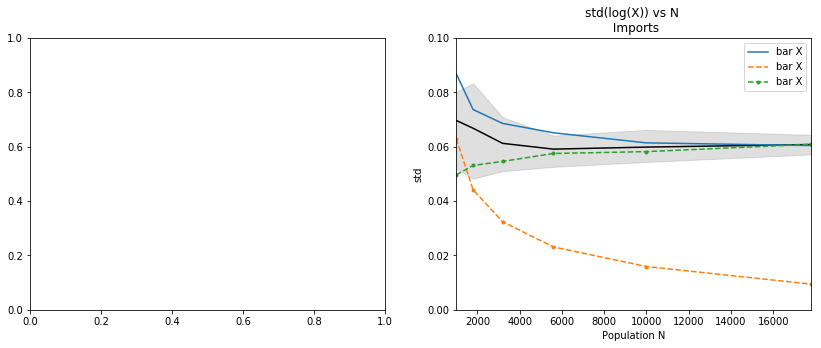

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

ax = axs[i]
ax.set_title(['std(log(X)) vs N \n Exports', 'std(log(X)) vs N \n Imports'][i])
ax.fill_between(result.index, result.quantile(.25, 1), result.quantile(.75, 1), color = '.5', alpha = .25)
ax.plot(result.index, result.mean(1), color = 'k')
std_all.plot(ax = ax)
std_idy.plot(ax = ax, linestyle = '--', marker = '.')
std_com.plot(ax = ax, linestyle = '--', marker = '.')
ax.set_ylim(0, .1)
ax.set_xlabel('Population N')
ax.set_ylabel('std')

plt.show()

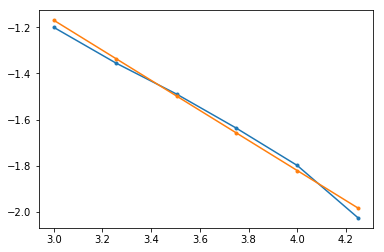

In [31]:
n = np.log10(std_idy.index.values).flatten()
y = np.log10(std_idy.values).flatten()

plt.plot(n, y, marker = '.')
# z = 1.9
plt.plot(n, -(.65)*n + .78 , marker = '.')

### Look at the variances vs Ntot which must have to do with the variances vs nq

In [19]:
df.drop(['Eij', 'ME', 'M'])
# (df.drop(['Eij', 'ME', 'M'])/(np.log(10)**2*X_df**2).T).T

,1000.0,1800.0,3200.0,5600.0,10000.0,17800.0
block,,,,,,
E0,4.454876e+15,6.987357e+15,1.075553e+16,1.954511e+16,2.712172e+16,2.519513e+16
E1,9.785412e+15,1.561046e+16,2.377539e+16,4.547788e+16,5.494071e+16,6.433886e+16
E2,2.139425e+16,2.789653e+16,4.426274e+16,8.007996e+16,1.114282e+17,1.052065e+17
E3,4.516078e+16,7.652891e+16,1.142104e+17,1.550853e+17,2.243605e+17,2.260345e+17
E4,1.135422e+17,1.964807e+17,2.231966e+17,3.554189e+17,5.867476e+17,6.646759e+17
E5,2.139208e+17,3.138629e+17,4.257631e+17,6.829462e+17,9.668600e+17,1.045134e+18
E6,2.447631e+17,4.798457e+17,8.450979e+17,1.513917e+18,2.305811e+18,2.168691e+18
E7,2.572102e+17,7.028364e+17,1.484936e+18,2.653212e+18,4.161517e+18,4.801731e+18
E8,2.365371e+17,5.350287e+17,1.866879e+18,3.032326e+18,5.392256e+18,5.745753e+18


In [20]:
nqs_df['mean'].unstack()

n,1000.0,1800.0,3200.0,5600.0,10000.0,17800.0
q,,,,,,
0,640.00,1182.55,2171.30,3784.95,6682.35,11782.40
1,188.85,337.45,585.10,1031.95,1877.20,3364.25
2,81.45,142.10,235.30,419.60,765.50,1391.15
3,41.65,67.25,108.55,191.50,354.30,651.10
4,21.75,34.15,52.25,91.40,167.45,316.35
5,11.95,17.85,26.10,44.65,84.20,160.70
6,6.90,9.75,12.20,21.40,42.30,80.65
7,3.90,4.65,5.55,9.20,17.45,35.40
8,1.80,2.35,2.15,3.55,6.35,13.80


### Are there sigma(n) expressions

 
-1.325 x - 1.628
 
-1.316 x - 2.031
 
-1.393 x - 2.072
 
-1.489 x - 1.967
 
-1.471 x - 2.069
 
-1.554 x - 2.124
 
-1.383 x - 2.534
 
-1.265 x - 2.901
 
-1.235 x - 3.371
 
-3.195 x - 2.307


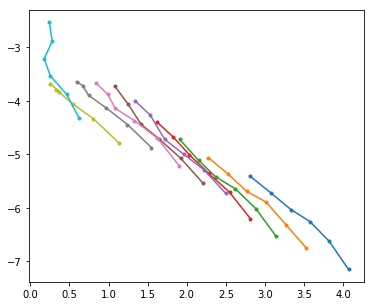

In [21]:
df_s2 = df.drop(['Eij', 'ME', 'M'])
df_s2log = df.drop(['Eij', 'ME', 'M']).div((np.log(10)**2*X_df**2).T.values, axis = 1)
df_x = nqs_df['mean'].unstack()

fig, axs = plt.subplots(1, figsize = (6, 5))

for i in range(Q):
    y = np.log10(df_s2log.iloc[i])
    x = np.log10(df_x.iloc[i])
    plt.plot(x, y, marker = '.')
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
#     xp = np.arange(3, 4.5, .25) 
    print(p)
        

plt.show()

In [23]:
df_s2log

block,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9
1000.0,3.960098e-06,8.698603e-06,1.901811e-05,4.014503e-05,0.000101,0.000190,0.000218,0.000229,0.000210,0.002948
1800.0,1.929658e-06,4.311051e-06,7.704025e-06,2.113455e-05,0.000054,0.000087,0.000133,0.000194,0.000148,0.001298
3200.0,9.227147e-07,2.039687e-06,3.797293e-06,9.798094e-06,0.000019,0.000037,0.000073,0.000127,0.000160,0.000616
5600.0,5.540247e-07,1.289114e-06,2.269943e-06,4.396041e-06,0.000010,0.000019,0.000043,0.000075,0.000086,0.000293
10000.0,2.358396e-07,4.777423e-07,9.689350e-07,1.950948e-06,0.000005,0.000008,0.000020,0.000036,0.000047,0.000133
17800.0,7.041662e-08,1.798175e-07,2.940365e-07,6.317327e-07,0.000002,0.000003,0.000006,0.000013,0.000016,0.000048


 
-0.9115 x - 2.9
 
-0.8945 x - 3.038
 
-0.8595 x - 3.261
 
-0.8172 x - 3.407
 
-0.842 x - 3.486
 
-0.8557 x - 3.701


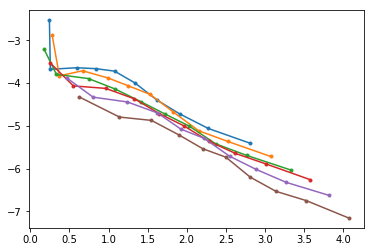

In [26]:
for i in range(len(n_vals)):
    y = np.log10(df_s2log.T.iloc[i])
    x = np.log10(df_x.T.iloc[i])
    plt.plot(x, y, marker = '.')
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
#     xp = np.arange(3, 4.5, .25) 
    print(p)
        

plt.show()

In [ ]:
# var_idy_lin = df.drop(['Eij', 'ME', 'M']).sum()

fig, axs = plt.subplots(1, figsize = (6, 5))

y = np.log10(var_idy.values.flatten())
x = np.log10(var_idy.index.values)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
xp = np.arange(3, 4.5, .25)
            
print(p)
plt.plot(x, y, marker = '.')
plt.plot(xp, p(xp))

plt.show()

In [ ]:
# ## Part of idiosynchratic variance due to each quantile
# df.drop(['Eij', 'ME', 'M']).div(df.drop(['Eij', 'ME', 'M']).sum())

In [ ]:
h_out = result_h.T.describe().T

n = np.log10(h_out.index.values).flatten()
y = np.log10(h_out['mean'].values).flatten()

fig, ax = plt.subplots(1, figsize = (7, 5))

ax.plot(n, y, marker = '.')
ax.fill_between(n, np.log10(h_out['25%']), np.log10(h_out['75%']), color = '.5', alpha = .25)
ax.plot(n, -(.4)*n +.55 , marker = '.')
plt.show()

In [ ]:
z = 1.16
print(-1 + 1/z)

## according to Gabaix log Herfindahl should go down as -0.12 (or -0.14 for exports) with log(n)

In [ ]:
sigma_eps_vals = out1.rename(columns = {'bar X': 'mean'})
h_vals = h_out.iloc[::2].iloc[:-1][['mean']]

In [ ]:

n = np.log10(h_out.index.values).flatten()[::2][:-1]
y2 = sigma_eps_vals.div(h_vals)

fig, ax = plt.subplots(1, figsize = (7, 5))

ax.plot(n, y2, marker = '.')
# ax.fill_between(n, np.log10(h_out['25%']), np.log10(h_out['75%']), color = '.5', alpha = .25)
# ax.plot(n, -(.4)*n +.55 , marker = '.')
plt.show()

In [ ]:
## Linear variance of parts:
var_Sp = df.drop(['Eij', 'ME', 'M'])#.sum()

# Expected total given how many agents are sampled:
X_bar = filt_fm.sum().mean()
n_max = len(filt_fm)
E_X_bar_n = (n_vals/n_max)*X_bar
E_X_bar_n

## Estimation of log variance of parts
var_log_Sp = Q**2*var_Sp.div(E_X_bar_n**2, axis = 1).div(np.log(10)**2, axis = 1)

## These are the sigma qs on which I compute the slope

sigmas = var_log_Sp
nqs = nqs_df.unstack()['mean']

for n in n_vals:
    x = np.log10(nqs[n].iloc[:Q])
    y = np.log10(sigmas[n].iloc[:Q])
    # plt.plot(x, y, marker = '.')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    print(n, p)

In [ ]:

aggvar = (df.drop(['Eij', 'ME', 'M']).sum()/((np.log(10)*X_df)**2).T).T # Only idiosynchratic error.

x = np.log10(aggvar.index.values)
y = np.log10(aggvar.values.flatten())
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
print(p)

plt.plot(x, y, marker = '.', label = 'obs')

n = np.log10(n_vals)
plt.plot(n, -(.85)*n, marker = '.', label = 'me')
plt.plot(n, -2*(1 - 1/1.16)*n - 2, marker = '.', label = 'Gab')
plt.legend()

In [ ]:
## At least in order of magnitude it is OK. 

## Next step would be seeing what are the actual log changes in the sqs with log changes in n.

In [ ]:
Dlog_varlogSp = np.log10(var_log_Sp).diff(axis = 1)
Dlog_np = np.log10(nqs).diff(axis = 1)
# Dlog_np = pd.Series(np.log10(n_vals), index = Dlog_varlogSp.columns).diff()

In [ ]:
np.log10(var_log_Sp).head()

In [ ]:
nqs.head()

In [ ]:
pd.Series(np.log10(n_vals), index = Dlog_varlogSp.columns).diff().values

In [ ]:
Dlog_np

In [ ]:
Dlog_np.T.plot(legend = False)
pd.Series(np.log10(n_vals), index = Dlog_varlogSp.columns).diff().plot(lw = 3, c = 'k', marker = 's')

In [ ]:
n = 9500
x = np.log10(nqs[n].iloc[:Q])
y = np.log10(sigmas[n].iloc[:Q])
# plt.plot(x, y, marker = '.')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
print(n, p)

In [ ]:
## It seems actually the sigma vs n is not a straight line...
for i in range(Q):
    x = np.log10(var_log_Sp).iloc[i]
    y = np.log10(nqs).iloc[i]
    
    z = np.polyfit(x[:5], y[:5], 1)
    p = np.poly1d(z)
    print(i, p)
    
    z = np.polyfit(x[-5:], y[-5:], 1)
    p = np.poly1d(z)
    print(i, p)
#     plt.plot(x, y, marker = '.')
# #     plt.plot(n, -2*(1 - 1/1.16)*n - 2, marker = '.')
#     plt.show()

In [ ]:
pd.DataFrame(Dlog_varlogSp.values/Dlog_np.values)

In [ ]:
Dlog_varlogSp.div(Dlog_np, axis = 1)